<div style="float:right; width:100px; text-align: center; margin: 10px;">
<img src="https://crypto-lake.com/assets/img/lake.png" alt="Lake"/>
</div>

# HFT backtest example

We use [crypto-lake.com](https://crypto-lake.com/#data) sample/free market data.

This is alpha version, not ready for usage yet.

TODO for higher performance and precision on bigger tokens (BTC, ETH, ...):
- update book_delta data to have structure without nesting
- migrate old book_delta data to new structure
- load book_delta data and implement conversion to hftbacktest

Quick links:
- [edit this notebook online](https://mybinder.org/v2/gh/crypto-lake/analysis-sharing/main?filepath=hftbacktest.ipynb) using Binder
- [follow our activity on twitter](https://twitter.com/intent/user?screen_name=crypto_lake_com)

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import datetime

import pandas as pd
import lakeapi
import hftbacktest
import lake_to_hftbacktest
from numba import njit

# cf.go_offline()

# lakeapi.use_sample_data(anonymous_access=True)


In [3]:
# Parameters
# symbol = 'FTRB-USDT'
# exchange = 'ASCENDEX'
symbol = 'SOL-USDT'
exchange = 'BINANCE'


# Free sample data contain subset of the below time period
# start = datetime.datetime(2022, 11, 1)
# end = datetime.datetime(2022, 11, 2)
start = datetime.datetime(2023, 12, 20)
end = datetime.datetime(2023, 12, 21)


## Data

In [7]:
print('Loading data')
trades = lakeapi.load_data(
    table = 'trades',
    start = start,
    end = end,
    symbols = [symbol],
    exchanges = [exchange],
    drop_partition_cols = True,
).sort_values('received_time')
# book = lakeapi.load_data(
#     table = 'book',
#     start = start,
#     end = end,
#     symbols = [symbol],
#     exchanges = [exchange],
#     drop_partition_cols = True,
# ).sort_values('received_time')
book = lakeapi.load_data(
    table = 'book_delta_v2',
    start = start,
    end = end,
    symbols = [symbol],
    exchanges = [exchange],
    drop_partition_cols = True,
).sort_values('received_time')


Loading data


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
ret = lake_to_hftbacktest.convert(
	input_dfs = [book, trades],
	output_filename = 'hftbacktest_data.npz',
)


 48%|████▊     | 2634474/5434573 [03:56<05:04, 9203.21it/s] 

In [10]:
book.iloc[0].origin_time.value


0

## Try out the data


In [4]:
hbt = hftbacktest.HftBacktest(
    'hftbacktest_data.npz',
    tick_size=0.000001,   # Tick size of a target trading asset
    lot_size=1,    # Lot size of a target trading asset, minimum trading unit.
    maker_fee=0.0002, # 0.02%, Maker fee, rebates if it is negative.
    taker_fee=0.0007, # 0.07%, Taker fee.
    order_latency=hftbacktest.FeedLatency(), # Latency model: ConstantLatency, FeedLatency.
    asset_type=hftbacktest.Linear, # Asset type: Linear, Inverse.
)


Load hftbacktest_data.npz


In [7]:
@njit(cache=True)
def dca_every_10m(hbt, recorder):
    ''' DCA with 10min frequency using limit order on best bid '''
    order_id = 1
    while hbt.run:
        # Times are in nanoseconds
        if not hbt.elapse(10 * 60 * 1e9):
            return False

        print(
            'timestamp_s:', hbt.current_timestamp // 1e9,
            ', best_bid:', round(hbt.best_bid, 9),
            ', best_ask:', round(hbt.best_ask, 9),
            ', position:', hbt.position,
            ', equity:', hbt.equity,
        )
        # Record statistics for analysis in the next cell
        recorder.record(hbt)
        hbt.clear_inactive_orders()
        # Try to buy some tokens every 10 minutes
        hbt.submit_buy_order(order_id, hbt.best_bid, 10_000, hftbacktest.GTC)
        order_id += 1
    return True


if not hbt.run:
	# If backtest already run and finished, reset it to be able to run this cell again
	hftbacktest.reset(hbt, 'hftbacktest_data.npz')

print('Running backtest')
stat = hftbacktest.Stat(hbt, unit = 'ns')
dca_every_10m(hbt, stat.recorder)


Load hftbacktest_data.npz
Running backtest
timestamp_s: 1667320796.0 , best_bid: 0.015991 , best_ask: 0.016005 , position: 0.0 , equity: 0.0
timestamp_s: 1667321396.0 , best_bid: 0.016064 , best_ask: 0.016073 , position: 0.0 , equity: 0.0
timestamp_s: 1667321996.0 , best_bid: 0.016017 , best_ask: 0.016026 , position: 10000.0 , equity: -0.45712799999998294
timestamp_s: 1667322596.0 , best_bid: 0.016005 , best_ask: 0.016015 , position: 20000.0 , equity: -0.6741620000000137
timestamp_s: 1667323196.0 , best_bid: 0.016005 , best_ask: 0.016015 , position: 20000.0 , equity: -0.6741620000000137
timestamp_s: 1667323796.0 , best_bid: 0.016005 , best_ask: 0.016015 , position: 20000.0 , equity: -0.6741620000000137
timestamp_s: 1667324396.0 , best_bid: 0.016009 , best_ask: 0.016018 , position: 20000.0 , equity: -0.6041619999999637
timestamp_s: 1667324996.0 , best_bid: 0.0161 , best_ask: 0.01611 , position: 20000.0 , equity: 1.2258380000000773
timestamp_s: 1667325596.0 , best_bid: 0.016199 , best_as

False

=========== Summary ===========
Sharpe ratio: -64.8
Sortino ratio: -54.2
Risk return ratio: -1058.9
Annualised return: -303.83 %
Max. draw down: 0.29 %
The number of trades per day: 9
Avg. daily trading volume: 97500
Avg. daily trading amount: 1576
Max leverage: 0.58
Median leverage: 0.08


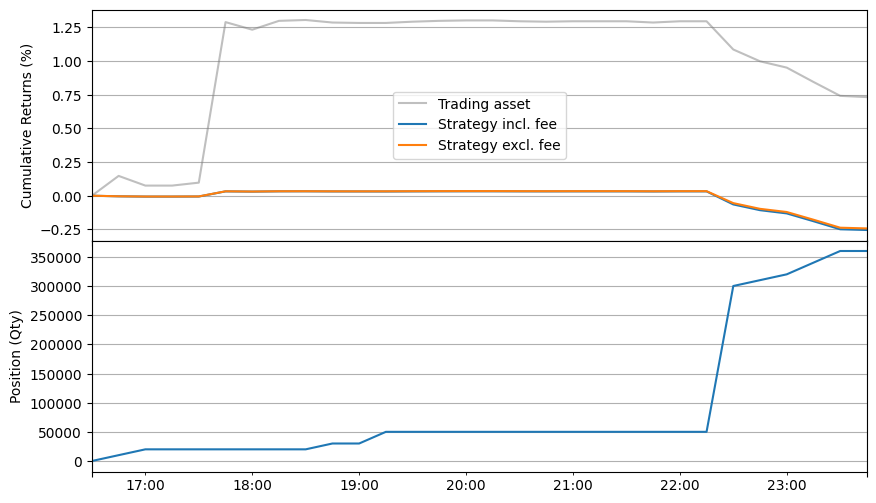

In [8]:
stat.summary(capital=10_000, resample='15min')
